In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

#check if cuda available
print(torch.__version__)
print(torch.version.cuda)

1.13.1
11.7


In [3]:
class ConvolutionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.out = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return F.log_softmax(x, dim=1)

In [4]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cuda')
torch.manual_seed(42)
model = ConvolutionNetwork()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [6]:
transform = transforms.Compose([
    transforms.ToTensor()
])
train_data = datasets.MNIST(root='/data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='/data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=500, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [7]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    for x_train, y_train in train_loader:
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss.cpu().detach())   
    print(f'epoch:{i}, train_loss:{loss}')

    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            
            y_val = model(x_test)
            loss = criterion(y_val, y_test)

    test_losses.append(loss.cpu().detach())
    print(f'epoch:{i}, test_losses:{loss}')

current_time = time.time()
total = current_time - start_time
print(f'trainning took {total/60} minutes')
    

epoch:0, train_loss:0.11221963167190552
epoch:0, test_losses:0.1382204294204712
epoch:1, train_loss:0.1000824123620987
epoch:1, test_losses:0.10945257544517517
epoch:2, train_loss:0.06273870170116425
epoch:2, test_losses:0.07578086853027344
epoch:3, train_loss:0.03728807717561722
epoch:3, test_losses:0.06161407381296158
epoch:4, train_loss:0.0393608883023262
epoch:4, test_losses:0.08156649768352509
trainning took 0.6564779281616211 minutes


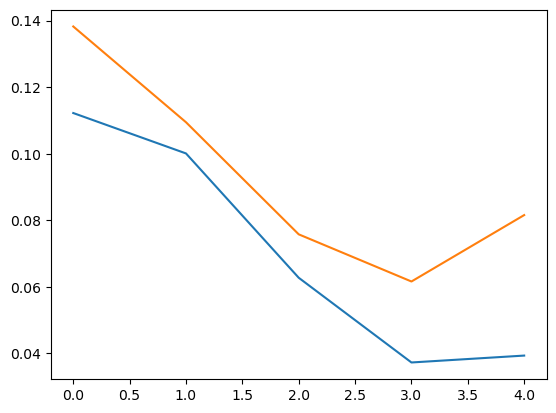

In [8]:
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')